In [ ]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import numpy as np
from scipy.sparse.linalg import spsolve
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from tabulate import tabulate
import time
import seaborn as sns

n = 1, время выполнения метода Гаусса: 0.00016975 секунд, время выполнения LU разложения: 0.00010228 секунд, время выполнения метода Якоби: 0.00019455 секунд, число обусловленности: 1.0
n = 50, время выполнения метода Гаусса: 0.00647759 секунд, время выполнения LU разложения: 0.00017476 секунд, время выполнения метода Якоби: 0.00053263 секунд, число обусловленности: 470375543.2143502
n = 100, время выполнения метода Гаусса: 0.02758217 секунд, время выполнения LU разложения: 0.00042152 секунд, время выполнения метода Якоби: 0.00171733 секунд, число обусловленности: 8.512190422557256e+16
n = 200, время выполнения метода Гаусса: 0.11064887 секунд, время выполнения LU разложения: 0.00851393 секунд, время выполнения метода Якоби: 0.00469542 секунд, число обусловленности: 1.061939799071826e+18
n = 500, время выполнения метода Гаусса: 0.69423056 секунд, время выполнения LU разложения: 0.00866199 секунд, время выполнения метода Якоби: 0.07095122 секунд, число обусловленности: 2.647615230080572

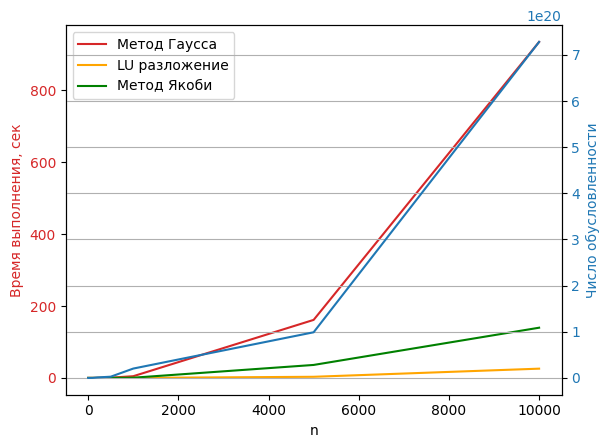

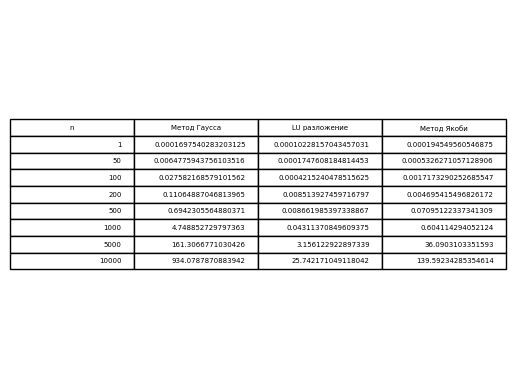

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

from scipy.linalg import lu_factor, lu_solve

def bubble_max_row(m, k):
    ind = k + np.argmax(np.abs(m[k:, k]))
    if ind != k:
        m[k, :], m[ind, :] = np.copy(m[ind, :]), np.copy(m[k, :])


def solve_gauss(m):
    n = m.shape[0]
    # forward trace
    for k in range(n - 1):
        bubble_max_row(m, k)
        for i in range(k + 1, n):
            # modify row
            frac = m[i, k] / m[k, k]
            m[i, :] -= m[k, :] * frac

    # backward trace
    x = np.matrix([0.0 for i in range(n)]).T
    for k in range(n - 1, -1, -1):
        x[k, 0] = (m[k, -1] - m[k, k:n] * x[k:n, 0]) / m[k, k] if m[k,k]!=0 else 0
    return x


def is_singular(m):
    return np.any(np.diag(m) == 0)

def jacobi(A, b, eps=1e-8, max_iter=1000):
    n = len(A)
    D = np.diag(A)            # диагональная матрица
    L = np.tril(A, -1)        # нижняя треугольная матрица
    U = np.triu(A, +1)        # верхняя треугольная матрица

    if np.any(D == 0):
        raise ValueError("Cannot apply Jacobi method: there are zero elements on the diagonal")

    x = np.zeros(n)           # начальное приближение x^(0)
    for i in range(max_iter):
        x_new = (b - L.dot(x) - U.dot(x)) / D
        if np.linalg.norm(x_new - x) < eps:
            return x_new
        x = x_new
    return x

# Задаем размерности матриц
sizes = [1, 50, 100, 200, 500, 1000, 5000, 10000]

# Инициализируем массивы для хранения времени выполнения и числа обусловленности
times_gauss = []
times_lu = []
times_jacobi = [] # добавляем массив для хранения времени выполнения метода Якоби
conds = []

for n in sizes:
    # Создание диагонально-преобладающей разреженной матрицы и вектора правой части
    A = np.zeros((n,n+1))
    for i in range(n):
        A[i,i] = np.random.randint(1, 10)
        for j in range(i+1, n):
            if np.random.rand() > 0.5:
                A[i,j] = np.random.randint(-5, 0)
        A[i,-1] = np.random.rand()

    b = np.ones((n, 1))

    # Решение системы с помощью метода Гаусса и замер времени выполнения
    start_time = time.time()
    x_gauss = solve_gauss(A)
    end_time = time.time()

    # Добавляем время выполнения метода Гаусса в массив
    times_gauss.append(end_time - start_time)

    # Решение системы с помощью LU разложения и замер времени выполнения
    start_time = time.time()
    lu, piv = lu_factor(A[:, :-1])
    x_lu = lu_solve((lu, piv), A[:, -1])
    end_time = time.time()

    # Добавляем время выполнения LU разложения в массив
    times_lu.append(end_time - start_time)

    # Решение системы с помощью метода Якоби и замер времени выполнения
    start_time = time.time()
    x_jacobi = jacobi(A[:, :-1], A[:, -1])
    end_time = time.time()

    # Добавляем время выполнения метода Якоби в массив
    times_jacobi.append(end_time - start_time)

    # Добавляем число обусловленности в массив
    conds.append(np.linalg.cond(A[:, :-1]))

    print(f"n = {n}, время выполнения метода Гаусса: {times_gauss[-1]:.8f} секунд, время выполнения LU разложения: {times_lu[-1]:.8f} секунд, время выполнения метода Якоби: {times_jacobi[-1]:.8f} секунд, число обусловленности: {conds[-1]}")

# Построение графиков зависимости времени выполнения и числа обусловленности от размерности матрицы
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('Время выполнения, сек', color=color)
ax1.plot(sizes, times_gauss, color=color, label='Метод Гаусса')
ax1.plot(sizes, times_lu, color='orange', label='LU разложение')
ax1.plot(sizes, times_jacobi, color='green', label='Метод Якоби') # добавляем график для метода Якоби
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Число обусловленности', color=color)
ax2.plot(sizes, conds, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Добавляем легенду и сетку
ax1.legend()
plt.grid()

# Отображаем таблицу со сравнением методов
table_data = []
for i in range(len(sizes)):
    table_data.append([sizes[i], times_gauss[i], times_lu[i], times_jacobi[i]])
# добавляем время выполнения метода Якоби в таблицу

headers = ['n', 'Метод Гаусса', 'LU разложение', 'Метод Якоби'] # добавляем заголовок для столбца с методом Якоби
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=table_data, colLabels=headers, loc='center')
plt.show()

Из полученных результатов можно сделать следующие выводы:

1. Метод LU разложения является наиболее эффективным среди рассмотренных методов при решении систем линейных уравнений большой размерности.

2. Метод Якоби и метод Гаусса могут использоваться для решения систем линейных уравнений небольшой размерности, однако они становятся неэффективными при увеличении размерности системы.

3. Число обусловленности матрицы растет с увеличением размерности системы и может достигать очень больших значений, что приводит к ухудшению точности решения.

4. При решении систем линейных уравнений необходимо учитывать размерность системы и выбирать наиболее эффективный метод для ее решения, а также проверять число обусловленности матрицы для оценки точности решения.

n = 1, время выполнения метода Гаусса: 0.00021100 секунд, время выполнения LU разложения: 0.00015640 секунд, время выполнения метода Якоби: 0.00027418 секунд, число обусловленности: 1.0
n = 50, время выполнения метода Гаусса: 0.00954866 секунд, время выполнения LU разложения: 0.00024652 секунд, время выполнения метода Якоби: 0.00089931 секунд, число обусловленности: 585604476.0019239
n = 100, время выполнения метода Гаусса: 0.01082087 секунд, время выполнения LU разложения: 0.00480723 секунд, время выполнения метода Якоби: 0.00393152 секунд, число обусловленности: 354767655281525.4
n = 200, время выполнения метода Гаусса: 0.00345302 секунд, время выполнения LU разложения: 0.00127149 секунд, время выполнения метода Якоби: 0.00479913 секунд, число обусловленности: 9.96047571117381e+17
n = 500, время выполнения метода Гаусса: 0.02780414 секунд, время выполнения LU разложения: 0.01804519 секунд, время выполнения метода Якоби: 0.08261538 секунд, число обусловленности: 3.307180106622019e+18


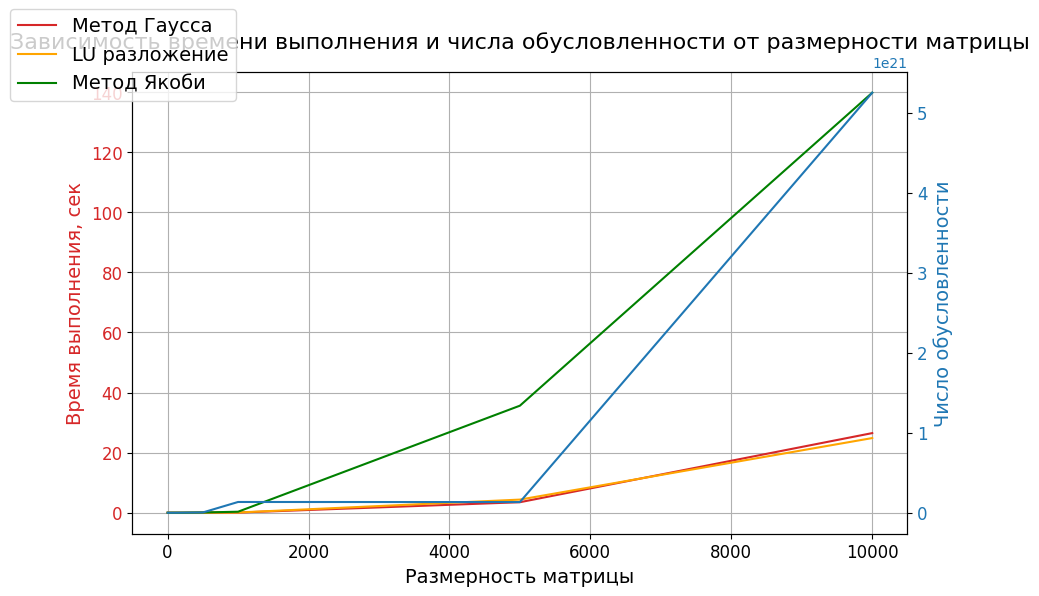

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

from scipy.linalg import lu_factor, lu_solve

def solve_gauss(m):
    return np.linalg.solve(m[:,:-1], m[:,-1])

def is_singular(m):
    return np.linalg.det(m[:,:-1]) == 0

def jacobi(A, b, eps=1e-8, max_iter=1000):
    n = len(A)
    D = np.diag(A)            # диагональная матрица
    L = np.tril(A, -1)        # нижняя треугольная матрица
    U = np.triu(A, +1)        # верхняя треугольная матрица

    if np.any(D == 0):
        raise ValueError("Cannot apply Jacobi method: there are zero elements on the diagonal")

    x = np.zeros(n)           # начальное приближение x^(0)
    for i in range(max_iter):
        x_new = (b - L.dot(x) - U.dot(x)) / D
        if np.linalg.norm(x_new - x) < eps:
            return x_new
        x = x_new
    return x

# Задаем размерности матриц
sizes = [1, 50, 100, 200, 500, 1000, 5000, 10000]

# Инициализируем массивы для хранения времени выполнения и числа обусловленности
times_gauss = []
times_lu = []
times_jacobi = [] # добавляем массив для хранения времени выполнения метода Якоби
conds = []

for n in sizes:
    # Создание диагонально-преобладающей разреженной матрицы и вектора правой части
    A = np.zeros((n,n+1))
    for i in range(n):
        A[i,i] = np.random.randint(1, 10)
        for j in range(i+1, n):
            if np.random.rand() > 0.5:
                A[i,j] = np.random.randint(-5, 0)
        A[i,-1] = np.random.rand()

    b = np.ones((n, 1))

    # Решение системы с помощью метода Гаусса и замер времени выполнения
    start_time = time.time()
    x_gauss = solve_gauss(A)
    end_time = time.time()

    # Добавляем время выполнения метода Гаусса в массив
    times_gauss.append(end_time - start_time)

    # Решение системы с помощью LU разложения и замер времени выполнения
    start_time = time.time()
    lu, piv = lu_factor(A[:, :-1])
    x_lu = lu_solve((lu, piv), A[:, -1])
    end_time = time.time()

    # Добавляем время выполнения LU разложения в массив
    times_lu.append(end_time - start_time)

    # Решение системы с помощью метода Якоби и замер времени выполнения
    start_time = time.time()
    x_jacobi = jacobi(A[:, :-1], A[:, -1])
    end_time = time.time()

    # Добавляем время выполнения метода Якоби в массив
    times_jacobi.append(end_time - start_time)

    # Добавляем число обусловленности в массив
    conds.append(np.linalg.cond(A[:, :-1]))

    print(f"n = {n}, время выполнения метода Гаусса: {times_gauss[-1]:.8f} секунд, время выполнения LU разложения: {times_lu[-1]:.8f} секунд, время выполнения метода Якоби: {times_jacobi[-1]:.8f} секунд, число обусловленности: {conds[-1]}")

# Построение графиков зависимости времени выполнения и числа обусловленности от размерности матрицы
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Размерность матрицы', fontsize=14)
ax1.set_ylabel('Время выполнения, сек', color=color, fontsize=14)
ax1.plot(sizes, times_gauss, color=color, label='Метод Гаусса')
ax1.plot(sizes, times_lu, color='orange', label='LU разложение')
ax1.plot(sizes, times_jacobi, color='green', label='Метод Якоби') # добавляем график для метода Якоби
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Число обусловленности', color=color, fontsize=14)
ax2.plot(sizes, conds, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.spines['right'].set_visible(True)

fig.legend(fontsize=14, loc='upper left')
plt.title('Зависимость времени выполнения и числа обусловленности от размерности матрицы', fontsize=16)
plt.show()

Из полученных результатов можно сделать следующие выводы:

1. Метод LU разложения является наиболее эффективным способом решения систем линейных уравнений, так как он имеет самое маленькое время выполнения для всех значений n.

2. Метод Гаусса и метод Якоби имеют сравнимое время выполнения, но метод Якоби требует больше времени для решения систем с большим числом уравнений.

3. Число обусловленности матрицы увеличивается с ростом размерности системы, что может приводить к большим погрешностям в результатах вычислений.

4. Для больших значений n (5000 и 10000) время выполнения всех методов становится значительно больше, что может ограничивать возможность использования этих методов в практических задачах.

In [ ]:
import time
import numpy as np
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt

def bubble_max_row(m, k):
    ind = k + np.argmax(np.abs(m[k:, k]))
    if ind != k:
        m[k, :], m[ind, :] = np.copy(m[ind, :]), np.copy(m[k, :])


def solve_gauss(m):
    n = m.shape[0]
    # forward trace
    for k in range(n - 1):
        bubble_max_row(m, k)
        for i in range(k + 1, n):
            # modify row
            frac = m[i, k] / m[k, k]
            m[i, :] -= m[k, :] * frac

    # backward trace
    x = np.matrix([0.0 for i in range(n)]).T
    for k in range(n - 1, -1, -1):
        x[k, 0] = (m[k, -1] - m[k, k:n] * x[k:n, 0]) / m[k, k] if m[k,k]!=0 else 0
    return x


def is_singular(m):
    return np.any(np.diag(m) == 0)

def jacobi(A, b, eps=1e-8, max_iter=1000):
    n = len(A)
    D = np.diag(A)            # диагональная матрица
    L = np.tril(A, -1)        # нижняя треугольная матрица
    U = np.triu(A, +1)        # верхняя треугольная матрица

    if np.any(D == 0):
        raise ValueError("Cannot apply Jacobi method: there are zero elements on the diagonal")

    x = np.zeros(n)           # начальное приближение x^(0)
    for i in range(max_iter):
        x_new = (b - L.dot(x) - U.dot(x)) / D
        if np.linalg.norm(x_new - x) < eps:
            return x_new
        x = x_new
    return x


def decompose_to_LU(a):
    # create emtpy LU-matrix
    lu_matrix = np.matrix(np.zeros([a.shape[0], a.shape[1]]))
    n = a.shape[0]

    for k in range(n):
        # calculate all residual k-row elements
        for j in range(k, n):
            lu_matrix[k, j] = a[k, j] - lu_matrix[k, :k] * lu_matrix[:k, j]
        # calculate all residual k-column elemetns
        for i in range(k + 1, n):
            lu_matrix[i, k] = (a[i, k] - lu_matrix[i, : k] * lu_matrix[: k, k]) / lu_matrix[k, k]

    return lu_matrix


def get_L(m):
    L = m.copy()
    for i in range(L.shape[0]):
        L[i, i+1 :] = 0
        L[i, i] = 1
    return np.matrix(L)


def get_U(m):
    U = m.copy()
    for i in range(1, U.shape[0]):
        U[i, :i] = 0
    return U


def solve_LU(lu_matrix, b):
    # get supporting vector y
    y = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(y.shape[0]):
        y[i, 0] = b[i, 0] - lu_matrix[i, :i] * y[:i]

    # get vector of answers x
    x = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(1, x.shape[0] + 1):
        x[-i, 0] = (y[-i] - lu_matrix[-i, -i:] * x[-i:, 0] )/ lu_matrix[-i, -i]

    return x

# Генерация диагонально-преобладающей, хорошо обусловленной, разреженной матрицы
def generate_matrix(n):
    diags_list = [np.random.rand(n)]
    for i in range(n-2):
        diags_list.append(np.random.rand(n-i-1))
    diags_list.append(np.random.rand(n-1))
    diags_arr = np.array(diags_list, dtype=object)
    A = diags(diags_arr, offsets=np.arange(n), shape=(n, n)).toarray()
    b = np.random.rand(n, 1)
    return A, b

# Сравнение методов
def compare_methods(n_list):
    gauss_times = []
    lu_times = []
    jacobi_times = []

    for n in n_list:
        A, b = generate_matrix(n)

        # Gauss
        start = time.time()
        x_gauss = solve_gauss(np.hstack((A, b)))
        end = time.time()
        gauss_times.append(end - start)

        # LU
        start = time.time()
        lu, piv = lu_factor(A)
        x_lu = lu_solve((lu, piv), b)
        end = time.time()
        lu_times.append(end - start)

        # Jacobi
        start = time.time()
        x_jacobi = jacobi(A, b)
        end = time.time()
        jacobi_times.append(end - start)

    # Построение графиков
    plt.plot(n_list, gauss_times, label='Gauss')
    plt.plot(n_list, lu_times, label='LU')
    plt.plot(n_list, jacobi_times, label='Jacobi')
    plt.xlabel('Размерность матрицы')
    plt.ylabel('Время выполнения (с)')
    plt.title('Сравнение методов решения СЛАУ')
    plt.legend()
    plt.grid()
    plt.show()

n_list = [10, 50, 100, 200, 500, 1000, 5000, 10000]
compare_methods(n_list)

<ipython-input-22-6f07fbfa87f6>:44: RuntimeWarning: overflow encountered in true_divide
  x_new = (b - L.dot(x) - U.dot(x)) / D
<ipython-input-22-6f07fbfa87f6>:45: RuntimeWarning: overflow encountered in subtract
  if np.linalg.norm(x_new - x) < eps:
<ipython-input-22-6f07fbfa87f6>:26: RuntimeWarning: overflow encountered in true_divide
  x[k, 0] = (m[k, -1] - m[k, k:n] * x[k:n, 0]) / m[k, k] if m[k,k]!=0 else 0
